In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


import statsmodels.tsa.api as smt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [4]:
data = 'pharmaceutical-sales-demand.xlsx'
pharma_df = pd.read_excel(data)

In [5]:
num2month = { "01":"jan", "02":"feb","03":"mar","04":"apr",
                "05":"may", "06":'jun', "07":"jul", "08": "Aug",
                "09":"Sep", "10":"Oct", "11":"Nov", "12": "Dec"}

def create_month(df, num2month = num2month):
    dt = str(df).split("-")
    return num2month[dt[1]]

In [6]:
pharma_df.sort_values(by = "Date", inplace= True)
pharma_df.reset_index(inplace= True)
pharma_df['month'] = pharma_df['Date'].map(create_month)

In [ ]:
pharma_df

,index,Date,Product ID,Stock Demand,month
0,62627,2020-10-01,1O0SN,1,Oct
1,4137,2020-10-01,E33NS,1,Oct
2,81910,2020-10-01,0S1OR,90,Oct
3,50643,2020-10-01,004IV,61,Oct
4,50647,2020-10-01,21GUL,2,Oct
...,...,...,...,...,...
1048570,1012092,2021-07-31,I0LP1,4,jul
1048571,1039877,2021-07-31,P03AM,1,jul
1048572,1036755,2021-07-31,R39OI,2,jul
1048573,1039684,2021-07-31,0XDY3,30,jul


In [ ]:
from cmath import nan

def check_datetime(item):
    if item.__class__ == pd._libs.tslibs.timestamps.Timestamp:
        return item
    else:
        return None

def remove_datetime(item):
    if type(item) == str:
        return item
    else:
       print("wrong_format {}".format(type(item)))
       return None

def check_month(id, number, df):
    """Checks the month which has the maximum sales of a product"""
    index = df.loc[df[id] == number].index
    return index[0]


In [ ]:
#Asserts that all entries are the same
pharma_df['Product ID'] = pharma_df['Product ID'].map(remove_datetime)
pharma_df['Date'] = pharma_df['Date'].map(check_datetime)

pharma_df = pharma_df.dropna()
pharma_df

In [114]:
#Asserts that there are no missing values in the dataset 

a = None in set(pharma_df['Product ID'])
b = None in set(pharma_df['Stock Demand'])

print(a)
print(b)

False
False


In [115]:
# Adding new features
# Adding categories of products can help detect change in demand, perhaps due to alternative products
# Adding price of items can also help detect if demand reduced because of price rise 
#It can be seen that stock demand was not taken on a consistent frequency each month. Thus we this can lead to inconsistencies while projecting

In [116]:
#Displaying sum of stock demand by each month 
yearly_demand_df = pharma_df.pivot_table(['Stock Demand'], index = 'Product ID', columns = 'month',aggfunc= sum)

In [117]:
yearly_demand_df = yearly_demand_df.droplevel(None, axis = 1)
yearly_demand_df = pd.DataFrame(yearly_demand_df, columns = ['Dec', 'Nov', 'Oct', 'apr', 'feb', 'jan', 'jul', 'mar', 'may'])

In [118]:
trans = yearly_demand_df.transpose()

In [119]:
trans.loc[trans['H0N7'] == 275200].index[0]

'Nov'

In [120]:
#Displays max demand of eat item over 12 months 

max_item_df = pd.DataFrame(yearly_demand_df.max(axis = 1), columns= ["Max Value(12 months)"]) #Obtaining months with maximum Stock Demand
max_item_df.reset_index(inplace= True)
max_item_df.sort_values(by = 'Max Value(12 months)', ascending = False, inplace= True) #In order to predict demand for top selling products
max_item_df = max_item_df.dropna()
max_item_df

,Product ID,Max Value(12 months)
200,03RAA,422246.0
5887,N8188,375338.0
3548,A03VX,290188.0
4866,H0N7,275200.0
5800,N0U4R,224162.0
...,...,...
151,02I0M,-5.0
107,01SFR,-10.0
1922,2AR4U,-25.0
5210,IDT10,-43.0


In [121]:
Top_5_items = list(max_item_df.head()['Product ID'])
Top_5_items

['03RAA', 'N8188', 'A03VX', 'H0N7', 'N0U4R']

In [122]:
max_item_df['month'] = [check_month(i,j, trans) for i,j in zip(max_item_df['Product ID'], max_item_df['Max Value(12 months)'])]
#Shows month where each item had maximum stock demand

In [123]:
max_item_df

,Product ID,Max Value(12 months),month
200,03RAA,422246.0,jan
5887,N8188,375338.0,Oct
3548,A03VX,290188.0,Nov
4866,H0N7,275200.0,Nov
5800,N0U4R,224162.0,jan
...,...,...,...
151,02I0M,-5.0,Nov
107,01SFR,-10.0,jul
1922,2AR4U,-25.0,mar
5210,IDT10,-43.0,Oct


In [124]:
avg_item_df = pd.DataFrame(yearly_demand_df.mean(axis = 1), columns= ["Average Value(12 months)"]) #Obtaining months with maximum Stock Demand
avg_item_df.reset_index(inplace= True)
avg_item_df.sort_values(by = 'Average Value(12 months)', ascending = False, inplace= True) #In order to predict demand for top selling products
avg_item_df

,Product ID,Average Value(12 months)
4866,H0N7,164751.111111
3676,A2SN0,115364.111111
5887,N8188,112865.333333
200,03RAA,104850.222222
3548,A03VX,74319.000000
...,...,...
5531,LASAC,NaN
5651,M11LP,NaN
6042,O0FA2,NaN
7298,T3I0T,NaN


In [125]:
min_item_df = pd.DataFrame(yearly_demand_df.min(axis = 1), columns= ["Min Value(12 months)"]) #Obtaining months with maximum Stock Demand
min_item_df.reset_index(inplace= True)
min_item_df.sort_values(by = 'Min Value(12 months)', ascending = False, inplace= True) #In order to predict demand for low selling products
min_item_df = min_item_df.dropna()
min_item_df

,Product ID,Min Value(12 months)
3676,A2SN0,65943.0
12,011ER,42514.0
5605,LP20H,29450.0
767,0NE1B,26126.0
7377,TER10,24665.0
...,...,...
5096,I50MG,-1064.0
7645,VL1O0,-1099.0
1685,1S0YS,-1826.0
7545,UOSTC,-4655.0


In [126]:
min_item_df['month'] = [check_month(i,j,trans) for i,j in zip(min_item_df['Product ID'], min_item_df['Min Value(12 months)'])]
min_item_df

,Product ID,Min Value(12 months),month
3676,A2SN0,65943.0,jul
12,011ER,42514.0,jul
5605,LP20H,29450.0,mar
767,0NE1B,26126.0,jul
7377,TER10,24665.0,jul
...,...,...,...
5096,I50MG,-1064.0,jan
7645,VL1O0,-1099.0,jul
1685,1S0YS,-1826.0,apr
7545,UOSTC,-4655.0,may


# Investigating Products with maximum sales to understand Demand

FILTER BY TOP 5 PRODUCTS

In [ ]:
products = list(pharma_df['Product ID'].unique())

#Creating dataframe for Top 5 products
#I6D04

df = []

for i,item in enumerate(Top_5_items):
    temp_df = pharma_df[pharma_df['Product ID'] == item]
    df.append(temp_df)

Top_5_df = pd.concat(df)
Top_5_df.sort_values(by= 'Date').reset_index().drop('level_0', axis = 1)

,index,Date,Product ID,Stock Demand,month
0,26158,2020-10-01,03RAA,94,Oct
1,96807,2020-10-01,A03VX,18,Oct
2,72495,2020-10-01,H0N7,652,Oct
3,45138,2020-10-01,N0U4R,-64,Oct
4,7753,2020-10-01,N0U4R,44,Oct
...,...,...,...,...,...
1479,1032767,2021-07-30,03RAA,5,jul
1480,1016241,2021-07-30,N0U4R,2461,jul
1481,1013025,2021-07-30,N0U4R,19274,jul
1482,1016089,2021-07-31,03RAA,5,jul


In [158]:
a = Top_5_df.groupby('Date')
a = pd.DataFrame(a)

list(a[0]) #Visually confirmed that Stock Demand readings were taken daily

[Timestamp('2020-10-01 00:00:00'),
 Timestamp('2020-10-02 00:00:00'),
 Timestamp('2020-10-03 00:00:00'),
 Timestamp('2020-10-04 00:00:00'),
 Timestamp('2020-10-05 00:00:00'),
 Timestamp('2020-10-06 00:00:00'),
 Timestamp('2020-10-07 00:00:00'),
 Timestamp('2020-10-08 00:00:00'),
 Timestamp('2020-10-09 00:00:00'),
 Timestamp('2020-10-10 00:00:00'),
 Timestamp('2020-10-11 00:00:00'),
 Timestamp('2020-10-12 00:00:00'),
 Timestamp('2020-10-13 00:00:00'),
 Timestamp('2020-10-14 00:00:00'),
 Timestamp('2020-10-15 00:00:00'),
 Timestamp('2020-10-16 00:00:00'),
 Timestamp('2020-10-17 00:00:00'),
 Timestamp('2020-10-18 00:00:00'),
 Timestamp('2020-10-19 00:00:00'),
 Timestamp('2020-10-20 00:00:00'),
 Timestamp('2020-10-21 00:00:00'),
 Timestamp('2020-10-22 00:00:00'),
 Timestamp('2020-10-23 00:00:00'),
 Timestamp('2020-10-24 00:00:00'),
 Timestamp('2020-10-25 00:00:00'),
 Timestamp('2020-10-26 00:00:00'),
 Timestamp('2020-10-27 00:00:00'),
 Timestamp('2020-10-28 00:00:00'),
 Timestamp('2020-10-

# Creating Lag features

In [129]:
#Using previous stock count as features
#Creating lag features 

for i in range(1, 10):
    Top_5_df[f'count_{i}'] = Top_5_df['Stock Demand'].shift(+i)

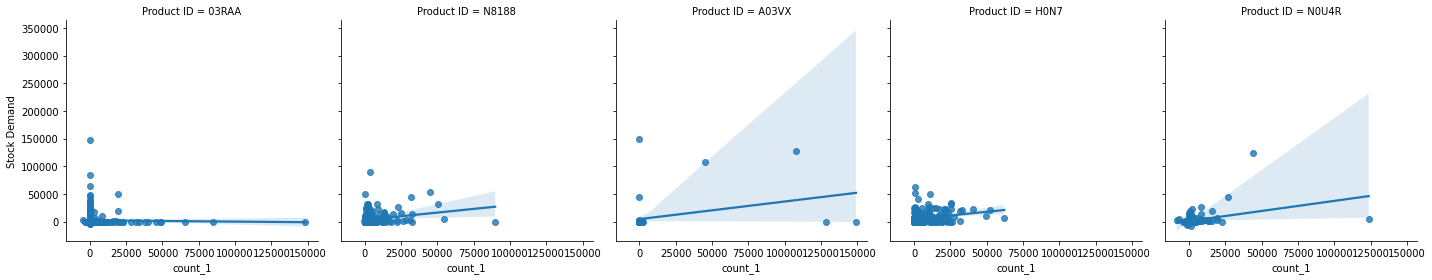

In [135]:
#Displays relationship between Stock Demand and number of lag days = 1
g = sns.FacetGrid(Top_5_df, col = "Product ID", height= 4)
g.map(sns.regplot, "count_1", "Stock Demand")

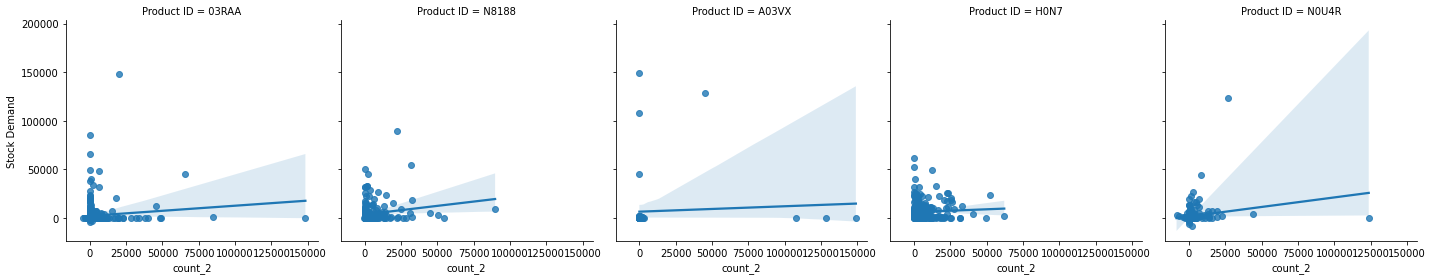

In [136]:
#Displays relationship between Stock Demand and number of lag days = 2
g = sns.FacetGrid(Top_5_df, col = "Product ID", height= 4)
g.map(sns.regplot, "count_2", "Stock Demand")

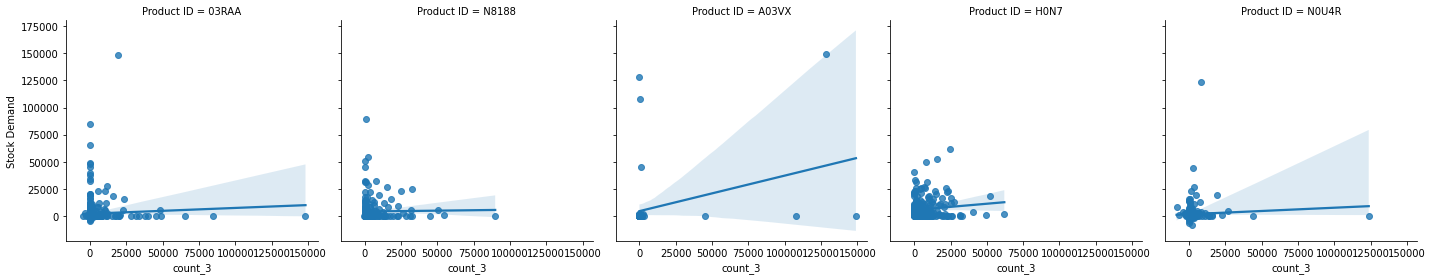

In [137]:
#Displays relationship between Stock Demand and number of lag days = 3
g = sns.FacetGrid(Top_5_df, col = "Product ID", height= 4)
g.map(sns.regplot, "count_3", "Stock Demand")

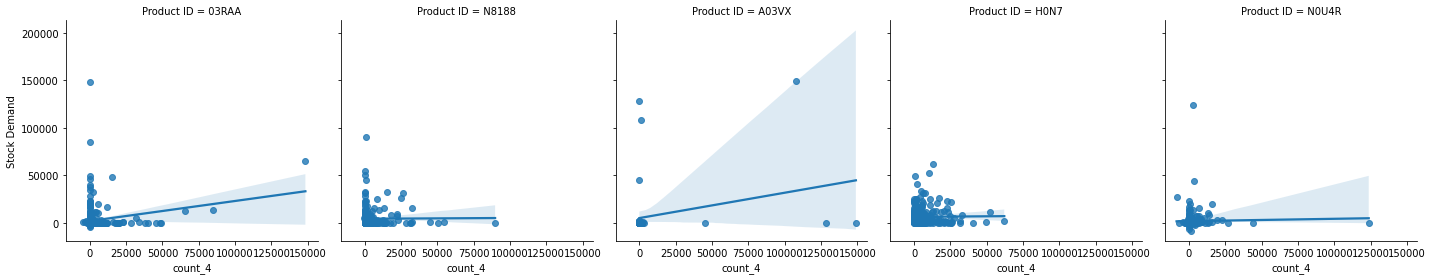

In [138]:
#Displays relationship between Stock Demand and number of lag days = 4
g = sns.FacetGrid(Top_5_df, col = "Product ID", height= 4)
g.map(sns.regplot, "count_4", "Stock Demand")

From these plots, it can be seen that after 5 days, there seems to be little relationship between the Stock Demand for previous 5 days and the current stock demand. for items 03RAA, A03VX

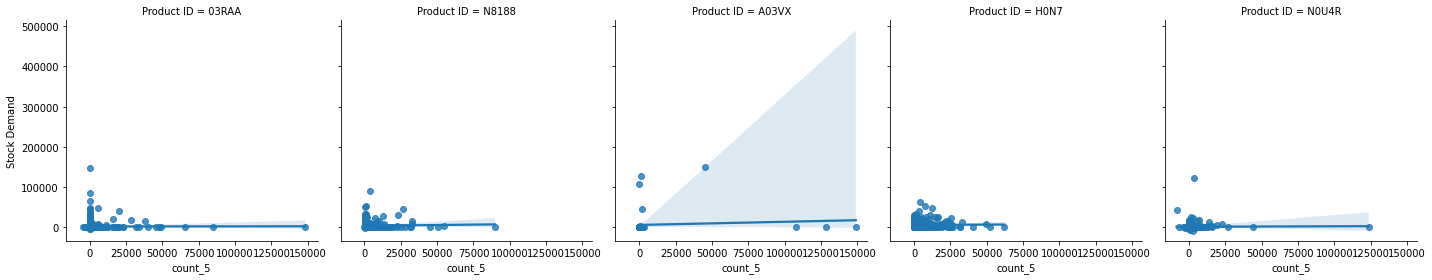

In [139]:
#Displays relationship between Stock Demand and number of lag days = 5

g = sns.FacetGrid(Top_5_df, col = "Product ID", height= 4)
g.map(sns.regplot, "count_5", "Stock Demand")

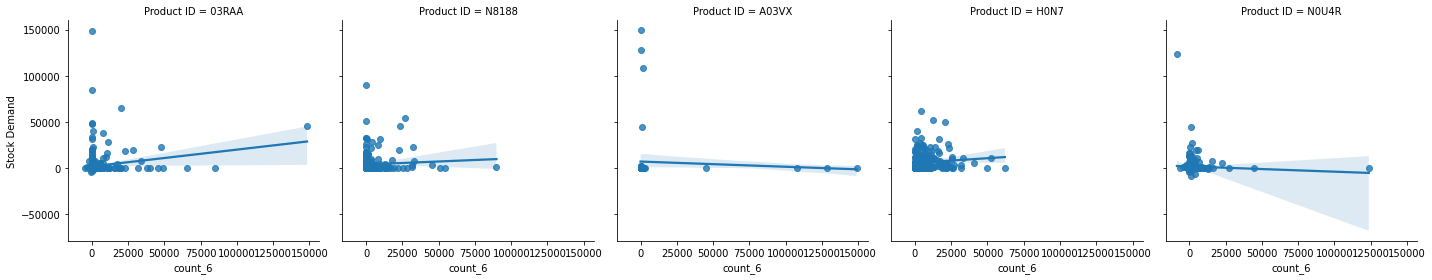

In [159]:
g = sns.FacetGrid(Top_5_df, col = "Product ID", height= 4)
g.map(sns.regplot, "count_6", "Stock Demand")

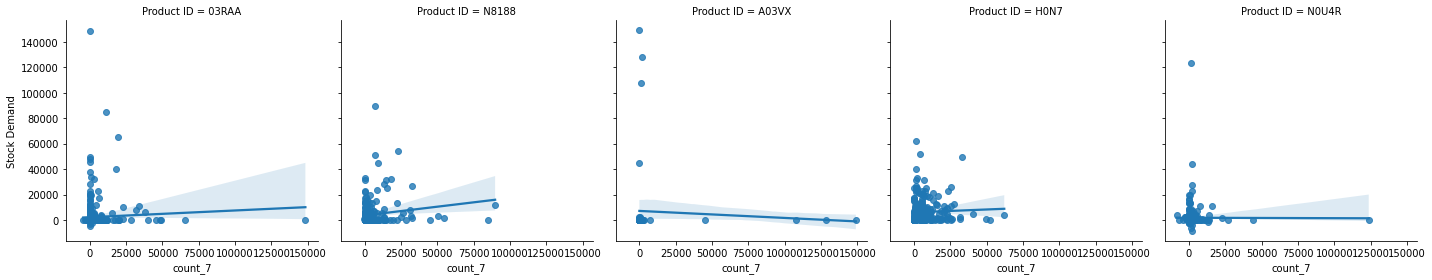

In [160]:
g = sns.FacetGrid(Top_5_df, col = "Product ID", height= 4)
g.map(sns.regplot, "count_7", "Stock Demand")

From these plots, it can be seen that after 5 days, there seems to be little relationship between the Stock Demand for previous 5 days and the current stock demand. For the initial model, the first 5 days lag features will be used

In [161]:
Top_5_df

,index,Date,Product ID,Stock Demand,month,count- 1,count- 2,count- 3,count- 4,count- 5,...,count- 9,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9
144,26158,2020-10-01,03RAA,94,Oct,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1250,20709,2020-10-01,03RAA,50,Oct,94.0,NaN,NaN,NaN,NaN,...,NaN,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6708,11297,2020-10-02,03RAA,38,Oct,50.0,94.0,NaN,NaN,NaN,...,NaN,50.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7247,27219,2020-10-02,03RAA,-2361,Oct,38.0,50.0,94.0,NaN,NaN,...,NaN,38.0,50.0,94.0,NaN,NaN,NaN,NaN,NaN,NaN
9686,77687,2020-10-04,03RAA,2,Oct,-2361.0,38.0,50.0,94.0,NaN,...,NaN,-2361.0,38.0,50.0,94.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044171,1042802,2021-07-28,N0U4R,6811,jul,19323.0,15901.0,272.0,4734.0,757.0,...,25.0,19323.0,15901.0,272.0,4734.0,757.0,7001.0,5698.0,1.0,25.0
1045129,1030882,2021-07-29,N0U4R,904,jul,6811.0,19323.0,15901.0,272.0,4734.0,...,1.0,6811.0,19323.0,15901.0,272.0,4734.0,757.0,7001.0,5698.0,1.0
1046988,1013025,2021-07-30,N0U4R,19274,jul,904.0,6811.0,19323.0,15901.0,272.0,...,5698.0,904.0,6811.0,19323.0,15901.0,272.0,4734.0,757.0,7001.0,5698.0
1047909,1016241,2021-07-30,N0U4R,2461,jul,19274.0,904.0,6811.0,19323.0,15901.0,...,7001.0,19274.0,904.0,6811.0,19323.0,15901.0,272.0,4734.0,757.0,7001.0


In [163]:
#Filtering columns in dataframe 

Top_5_df = Top_5_df[['index', 'Date', 'Product ID', 'Stock Demand', 'month', 'count_1', 'count_2', 'count_3', 'count_4', 'count_5']]
Top_5_df

,index,Date,Product ID,Stock Demand,month,count_1,count_2,count_3,count_4,count_5
144,26158,2020-10-01,03RAA,94,Oct,NaN,NaN,NaN,NaN,NaN
1250,20709,2020-10-01,03RAA,50,Oct,94.0,NaN,NaN,NaN,NaN
6708,11297,2020-10-02,03RAA,38,Oct,50.0,94.0,NaN,NaN,NaN
7247,27219,2020-10-02,03RAA,-2361,Oct,38.0,50.0,94.0,NaN,NaN
9686,77687,2020-10-04,03RAA,2,Oct,-2361.0,38.0,50.0,94.0,NaN
...,...,...,...,...,...,...,...,...,...,...
1044171,1042802,2021-07-28,N0U4R,6811,jul,19323.0,15901.0,272.0,4734.0,757.0
1045129,1030882,2021-07-29,N0U4R,904,jul,6811.0,19323.0,15901.0,272.0,4734.0
1046988,1013025,2021-07-30,N0U4R,19274,jul,904.0,6811.0,19323.0,15901.0,272.0
1047909,1016241,2021-07-30,N0U4R,2461,jul,19274.0,904.0,6811.0,19323.0,15901.0


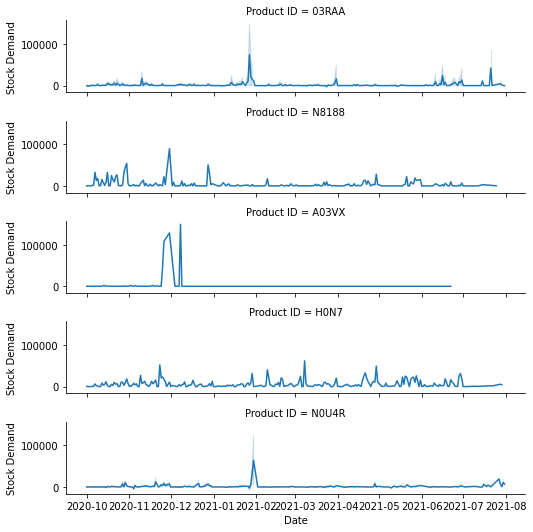

In [173]:
g = sns.FacetGrid(Top_5_df, row="Product ID", height = 1.5, aspect = 5)
g.map(sns.lineplot, "Date", "Stock Demand")

This lineplot shows sudden spikes in stock demand for products sucs as A03VX. The reason behind this cannot be explained solely from the plots. It could be due to the lack of an alternative product, disease outbreak etc.

Product ID N0U4R also sees spikes in Stock Demand, which cannot be explained. From these top 5 items, product ID H0N7 also sees a steady rise in stock demand.

In [203]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def plot_moving_average(ax, i, series, window = 5, plot_intervals = False, scale = 1.96):
    rolling_mean = series.rolling(window = window).mean()
    #Series in df
    ax[i].set_title("Moving average \n window size = {}".format(window))
    ax[i].plot(rolling_mean, 'g', label = 'Rolling mean trend')

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae - scale * deviation)
        upper_bound = rolling_mean - (mae - scale * deviation)
        ax[i].plot(upper_bound, 'r--', label = 'Upper bound')
        ax[i].plot(lower_bound, 'r--', )
    
    ax[i].plot(series[window:], label = 'Actual values')
    ax[i].legend(loc = 'best')
    ax[i].grid(True)
    return ax
#plot_moving_average(prod_1['Stock Demand'], 10, plot_intervals= True) #Stock Demand was not taken on a consistent basis which is why
#varying our window does not necessarily provide information on product performance weekly or monthly.

In [184]:
Top_5_df[Top_5_df['Product ID'] == 'N8188']['Stock Demand']

1294        114
5107        676
8938         37
9485         57
13614      1475
           ... 
1009213       1
1016798       1
1020989     286
1025520    3046
1038683     429
Name: Stock Demand, Length: 249, dtype: int64

array([<AxesSubplot:title={'center':'Moving average \n window size = 5'}>,
       <AxesSubplot:title={'center':'Moving average \n window size = 5'}>,
       <AxesSubplot:title={'center':'Moving average \n window size = 5'}>,
       <AxesSubplot:title={'center':'Moving average \n window size = 5'}>,
       <AxesSubplot:title={'center':'Moving average \n window size = 5'}>],
      dtype=object)

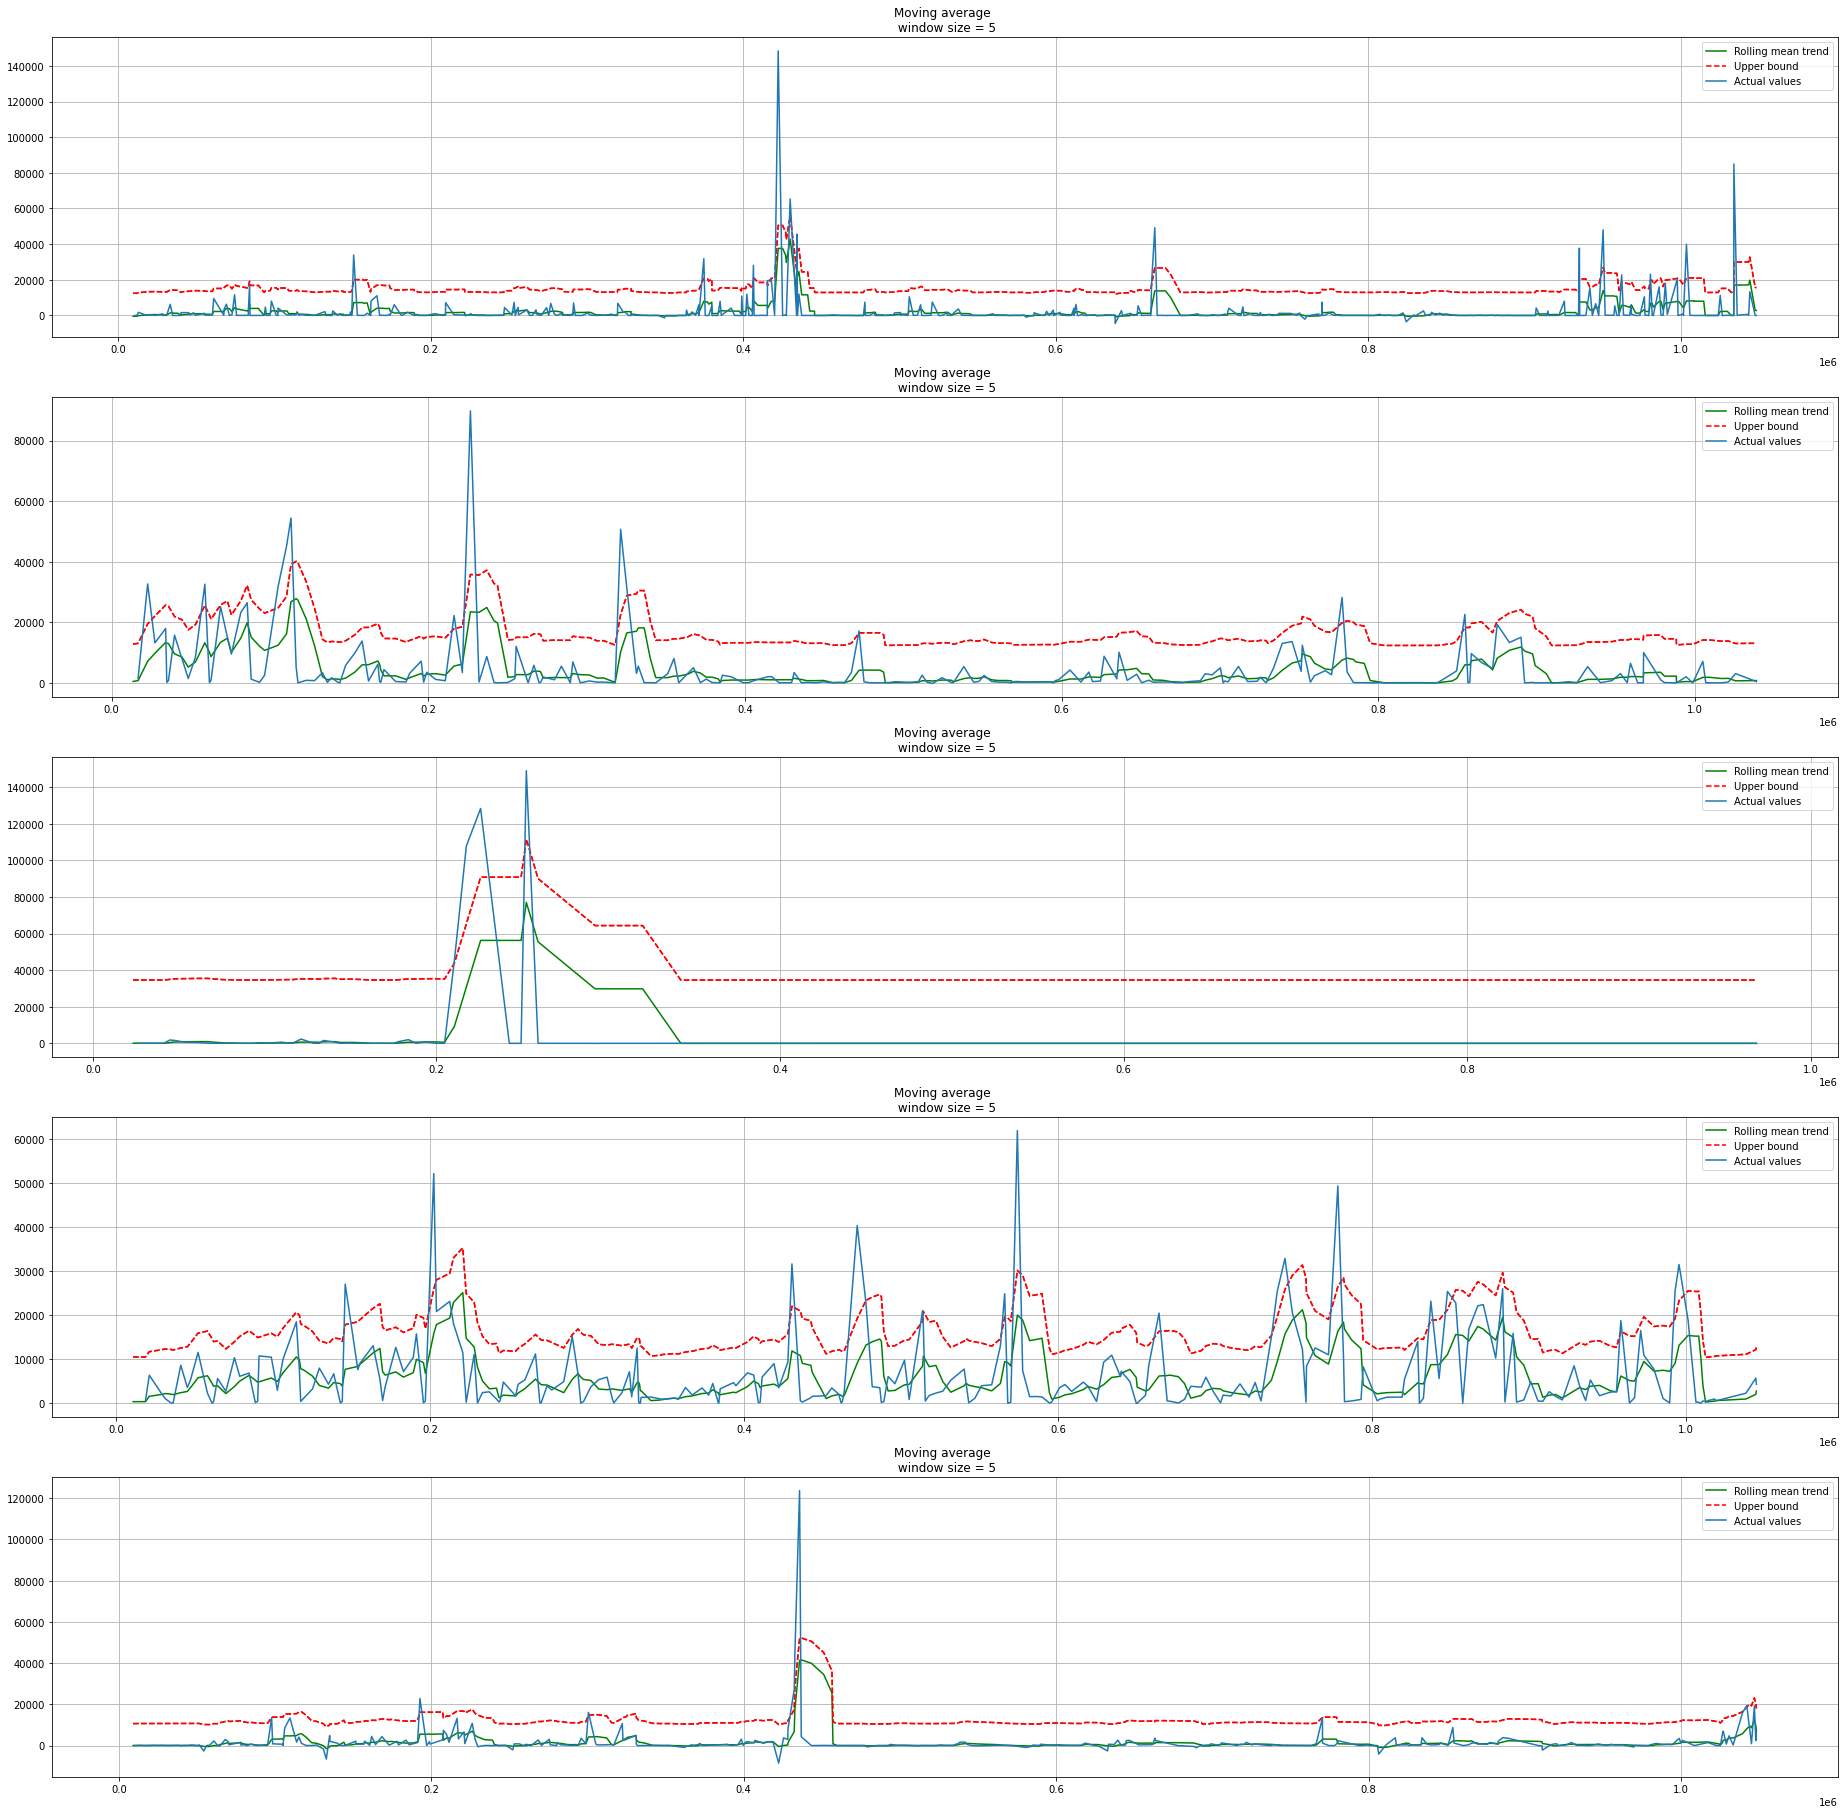

In [211]:
fig, ax = plt.subplots(5,1, figsize = (32,32))

plot_moving_average(ax, 0, Top_5_df[Top_5_df['Product ID'] == '03RAA']['Stock Demand'], plot_intervals = True)
plot_moving_average(ax, 1, Top_5_df[Top_5_df['Product ID'] == 'N8188']['Stock Demand'], plot_intervals = True)
plot_moving_average(ax, 2, Top_5_df[Top_5_df['Product ID'] == 'A03VX']['Stock Demand'], plot_intervals = True)
plot_moving_average(ax, 3, Top_5_df[Top_5_df['Product ID'] == 'H0N7']['Stock Demand'], plot_intervals = True)
plot_moving_average(ax, 4, Top_5_df[Top_5_df['Product ID'] == 'N0U4R']['Stock Demand'], plot_intervals = True)

In [212]:
!pip install statsmodels

You should consider upgrading via the '/Users/max/Desktop/Code/nlp_venv/bin/python3 -m pip install --upgrade pip' command.


As an instance product ID H0N7 will be modelled to explore the relationship

In [213]:
HON7_df = Top_5_df[Top_5_df['Product ID'] == 'H0N7']
HON7_df

,index,Date,Product ID,Stock Demand,month,count_1,count_2,count_3,count_4,count_5
2990,72495,2020-10-01,H0N7,652,Oct,1.0,3.0,2.0,1.0,2.0
8193,38156,2020-10-02,H0N7,333,Oct,652.0,1.0,3.0,2.0,1.0
9399,99622,2020-10-03,H0N7,45,Oct,333.0,652.0,1.0,3.0,2.0
10455,98687,2020-10-04,H0N7,129,Oct,45.0,333.0,652.0,1.0,3.0
11042,28636,2020-10-05,H0N7,690,Oct,129.0,45.0,333.0,652.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1018086,1033319,2021-07-09,H0N7,965,jul,655.0,355.0,532.0,9.0,221.0
1019251,1011136,2021-07-12,H0N7,592,jul,965.0,655.0,355.0,532.0,9.0
1038037,1036685,2021-07-23,H0N7,2290,jul,592.0,965.0,655.0,355.0,532.0
1044366,1040415,2021-07-28,H0N7,5731,jul,2290.0,592.0,965.0,655.0,355.0


/Users/max/Desktop/Code/nlp_venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/Users/max/Desktop/Code/nlp_venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


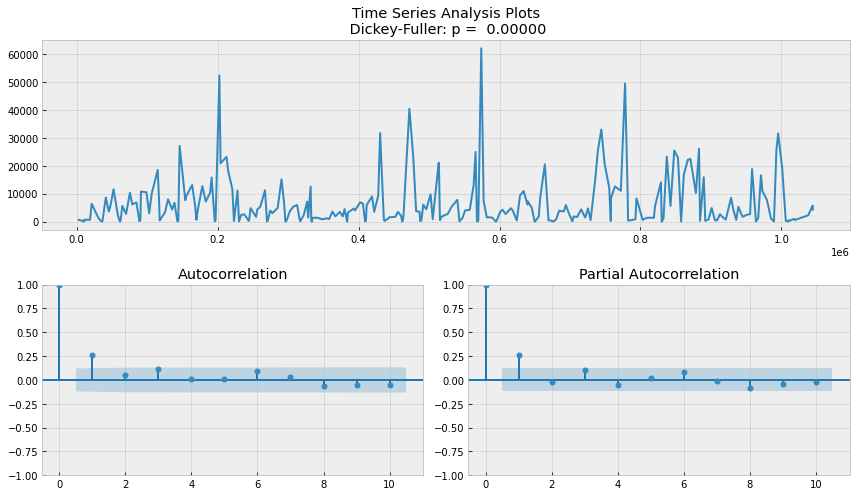

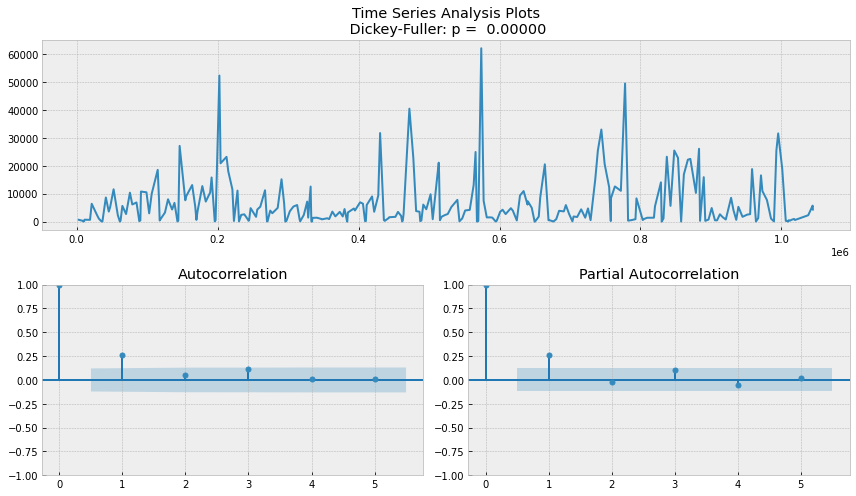

In [215]:
#Dickey Fuller's test to check correlation between plots
#Correlation plot to determine which lag features impact stock demand


def tsplot(y, lags = None, figsize = (12,7), style = 'bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style = 'bmh'):
        fig = plt.figure(figsize = figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan = 2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax = ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p = {0: .5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags = lags, ax = acf_ax)
        smt.graphics.plot_pacf(y, lags = lags, ax = pacf_ax)
        plt.tight_layout()

tsplot(HON7_df['Stock Demand'], lags = 10)
daily_change = HON7_df['Stock Demand'] - HON7_df['Stock Demand'].shift(1)

tsplot(HON7_df['Stock Demand'], lags = 5) 

It can be seen from the 10-day auto correlation plot that, only the previous day model has an impact on current day Demand for HON7

In [221]:
#Split first product into train and test 


HON7_train,HON7_test = train_test_split(HON7_df, test_size = 0.3)

In [217]:
HON7_train

,index,Date,Product ID,Stock Demand,month,count_1,count_2,count_3,count_4,count_5
669515,701577,2021-04-01,H0N7,514,apr,20507.0,8684.0,1809.0,24.0,5.0
541443,503382,2021-02-27,H0N7,4660,feb,7795.0,5244.0,2748.0,2317.0,1775.0
419155,417602,2021-01-26,H0N7,9011,jan,5965.0,218.0,150.0,6427.0,6924.0
589790,606672,2021-03-12,H0N7,1448,mar,1538.0,1511.0,7445.0,62008.0,237.0
373336,343132,2021-01-13,H0N7,3487,jan,1887.0,3584.0,916.0,1211.0,815.0
...,...,...,...,...,...,...,...,...,...,...
220963,117501,2020-11-27,H0N7,11538,Nov,18037.0,23180.0,20870.0,52240.0,508.0
842651,797069,2021-05-19,H0N7,5641,may,23220.0,1123.0,9.0,14062.0,5492.0
680539,737650,2021-04-05,H0N7,905,apr,60.0,480.0,514.0,20507.0,8684.0
684571,736742,2021-04-06,H0N7,3882,apr,905.0,60.0,480.0,514.0,20507.0


In [226]:
HON7_train[['month', 'count_1',
 'count_2',
 'count_3',
 'count_4',
 'count_5']]

,month,count_1,count_2,count_3,count_4,count_5
419155,5,5965.0,218.0,150.0,6427.0,6924.0
526616,4,2317.0,1775.0,512.0,17380.0,21082.0
669515,3,20507.0,8684.0,1809.0,24.0,5.0
41403,2,44.0,110.0,1055.0,2224.0,6391.0
1007981,6,287.0,18909.0,31556.0,25465.0,87.0
...,...,...,...,...,...,...
267278,0,5335.0,4344.0,1719.0,4829.0,530.0
680539,3,60.0,480.0,514.0,20507.0,8684.0
735854,3,524.0,4734.0,1419.0,4407.0,1663.0
327088,0,2404.0,100.0,860.0,5947.0,5390.0


In [284]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder() #transforms month column

HON7_train['month'] = le.fit_transform(HON7_train['month'])
HON7_test['month'] = le.fit_transform(HON7_test['month'])

def train_model(df,features:list, target, model, params = {}):
    """Creates trained models based on features and target"""
    model = model(**params)
    trained_model = model.fit(df[features], target)
    return trained_model

rf_model = RandomForestRegressor()
rf_model.fit(HON7_train[['month', 'count_1',
 'count_2',
 'count_3',
 'count_4',
 'count_5']], HON7_train['Stock Demand'])


model = XGBRegressor()
model.fit(HON7_train[['month', 'count_1',
 'count_2',
 'count_3',
 'count_4',
 'count_5']], HON7_train['Stock Demand'])

output_rf = rf_model.predict(HON7_test[['month',
 'count_1',
 'count_2',
 'count_3',
 'count_4',
 'count_5']])

output_rf_train = rf_model.predict(HON7_train[['month',
 'count_1',
 'count_2',
 'count_3',
 'count_4',
 'count_5']])

output_train = model.predict(HON7_train[['month',
 'count_1',
 'count_2',
 'count_3',
 'count_4',
 'count_5']])

output= model.predict(HON7_test[['month',
 'count_1',
 'count_2',
 'count_3',
 'count_4',
 'count_5']])

error_rf = mean_squared_error(HON7_test['Stock Demand'], output_rf)
error = mean_squared_error(HON7_test['Stock Demand'], output)
error,error_rf

#retry with standardization

#Calculating Residuals 
residuals = HON7_train['Stock Demand'] - output_train
residuals

residuals_rf = HON7_train['Stock Demand'] - output_rf_train
residuals_rf

419155     1447.61
526616      117.32
669515    -5011.01
41403      2257.34
1007981   -2393.10
            ...   
267278     1998.51
680539     -899.54
735854     3827.21
327088     1132.72
905720    -2573.95
Name: Stock Demand, Length: 184, dtype: float64

In [292]:
#Modularize code for and create pipeline

def train_model(df,features:list, target, model, params = {}):
    """Creates trained models based on features and target"""
    model = model(**params)
    trained_model = model.fit(df[features], target)
    return trained_model


TypeError: 'XGBRegressor' object is not callable

/Users/max/Desktop/Code/nlp_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/max/Desktop/Code/nlp_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/max/Desktop/Code/nlp_venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

<AxesSubplot:title={'center':'Residuals on train set [Random Forest]'}, xlabel='Date', ylabel='Stock Demand'>

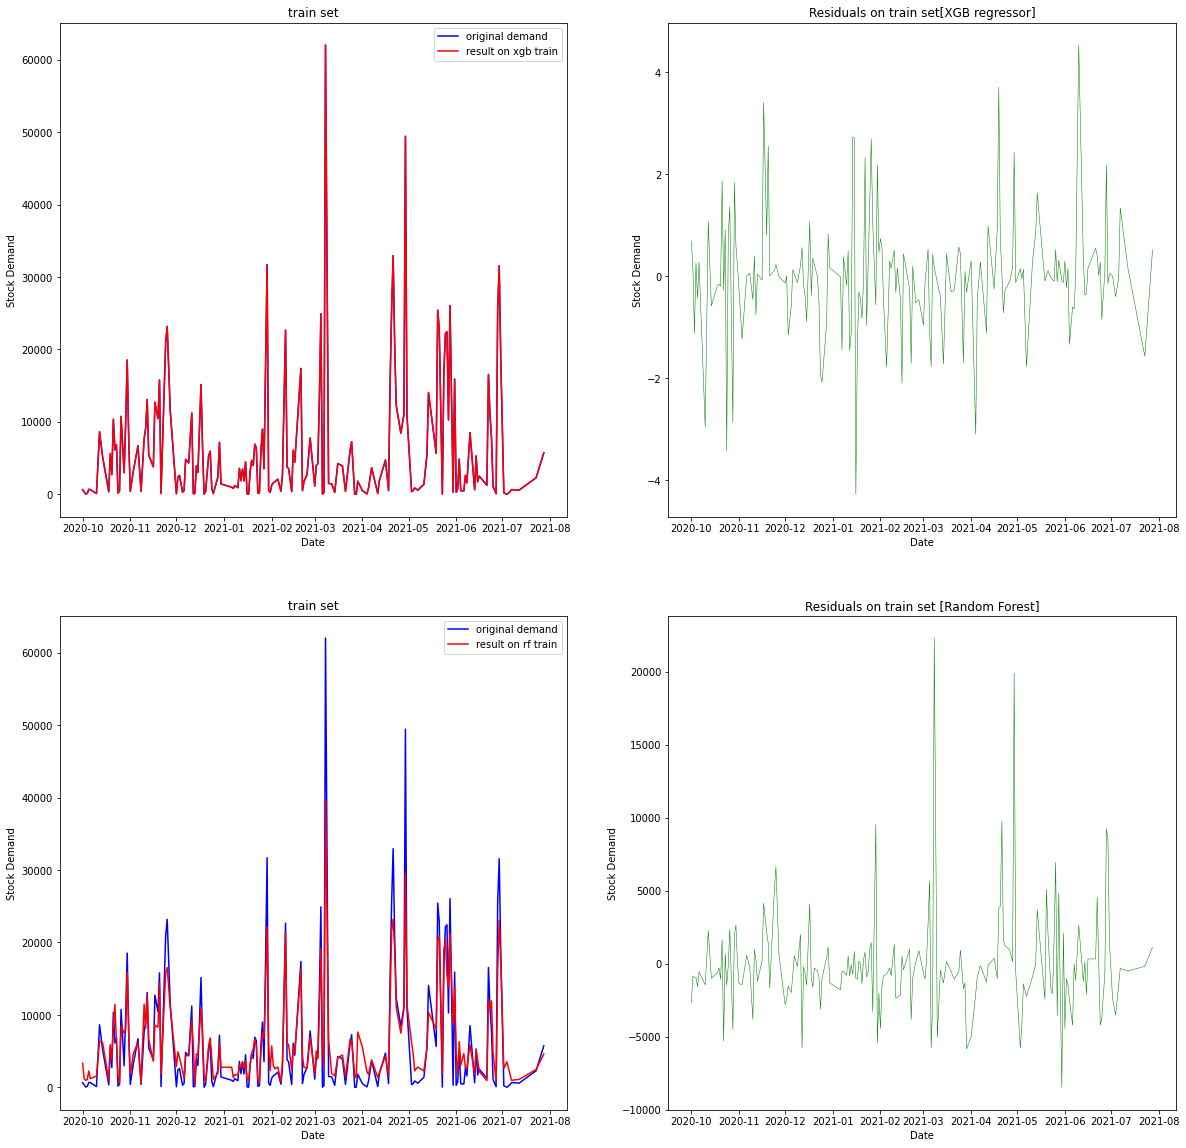

In [291]:
#Checking predictions of Random Forest on train set

f = plt.figure(figsize = (20,20)) #sets figures
g = f.add_gridspec(2,2) #partitions columns

ax = f.add_subplot(g[0,0])
ax.set_title('train set')
sns.lineplot(HON7_train['Date'], HON7_train['Stock Demand'], color = 'b', label = 'original demand')
sns.lineplot(HON7_train['Date'], output_train, color = 'r', label = 'result on xgb train')
ax.legend()

ax= f.add_subplot(g[0,1])
ax.set_title('Residuals on train set[XGB regressor]')
sns.lineplot(HON7_train['Date'], residuals, color = 'g', linewidth = 0.5)

ax = f.add_subplot(g[1,0])
ax.set_title('train set')
sns.lineplot(HON7_train['Date'], HON7_train['Stock Demand'], color = 'b', label = 'original demand')
sns.lineplot(HON7_train['Date'], output_rf_train, color = 'r', label = 'result on rf train')
ax.legend()

ax= f.add_subplot(g[1,1])
ax.set_title('Residuals on train set [Random Forest]')
sns.lineplot(HON7_train['Date'], residuals_rf, color = 'g', linewidth = 0.5)

XGB Regressor tends to overfit on training data due to the low amount of training data, therefore we go along with Random Forest, tweak the hyperparameters and create an hybrid model to account for the residuals

In [ ]:
#Hyperparameter tuning
#Cross-validation